## Artificial vortex array flow test

## Averaged flows


In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
import pickle 
import os
import sys
import pandas as pd

sys.path.append('../defect_functions') 
from defect_pairs import * 
from average_flows import * 

%matplotlib qt


# image_list = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\*.tif")
image_list = glob.glob(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\ISF defects new\6\*.tif")
# image_list = glob.glob(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\10X defect\10 mix in red right panel\*.tif")
# image_list = glob.glob(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\20X defect\20 mix in red right panel\*.tif")
image_list = natsorted(image_list, key=lambda y: y.lower())

### Test flow parameters
`flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)`

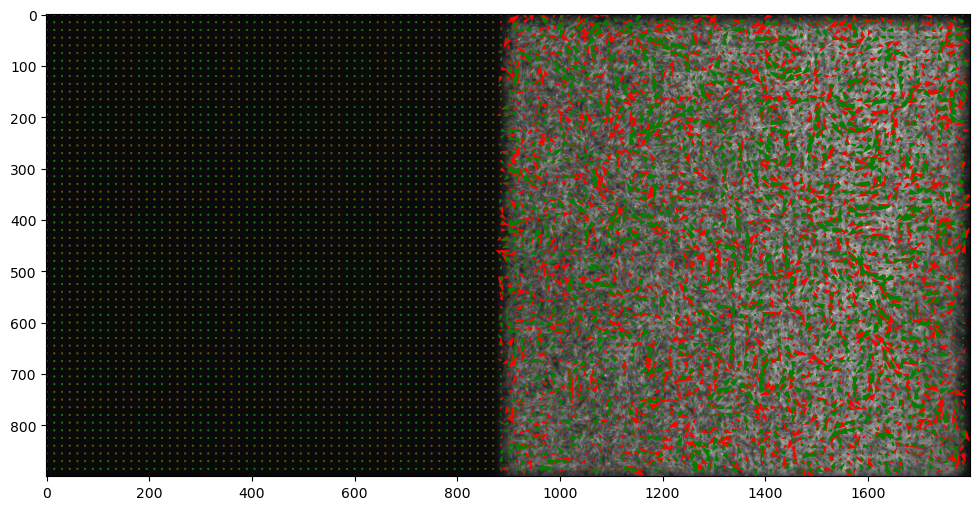

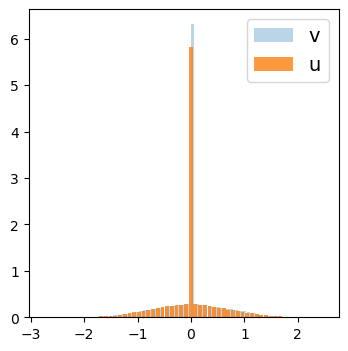

In [2]:
%matplotlib inline
skip = 1
n = 10 * skip

u = np.zeros_like(cv2.imread(image_list[0])[:,:,0], dtype=np.float32)
v = np.zeros_like(u)

for (i,im1), im2 in zip(enumerate(image_list[:n:skip]), image_list[1:n+1:skip]):

    img1 = cv2.imread(im1)[:,:,0]
    img2 = cv2.imread(im2)[:,:,0]
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) 
    u += flow[..., 0]
    v += flow[..., 1]

step = 15
fig, ax1 = plt.subplots(1,1,  figsize=(12,6))
ax1.imshow(img1, cmap="gray")

x = np.arange(0, flow.shape[1], step, dtype=np.int16)
y = np.arange(0, flow.shape[0], step, dtype=np.int16)
ax1.quiver(x,y, 
        flow[::step, ::step, 0], -flow[::step, ::step, 1], 
        color="red", scale=150)
ax1.quiver(x,y, 
        u[::step, ::step]/(i+1), -v[::step, ::step]/(i+1), 
        color="green", scale=150)

fig, ax2 = plt.subplots(1,1,  figsize=(4,4))
ax2.hist(np.concatenate(v)/(i+1), 60, alpha=.3, rwidth=.9, density=True, label="v")
ax2.hist(np.concatenate(u)/(i+1),60, alpha=.8, rwidth=.8, density=True, label="u")
plt.legend(loc='upper right', fontsize=14)

In [ ]:
%matplotlib inline
SAVE = True
PLOT = False
CHECK  = False

for (i,im1), im2 in zip(enumerate(image_list[:-1]), image_list[1:]):
    #right image [:,900:,0] / left image [:,:900,0]
    img1 = cv2.imread(im1)[:,900:,0]
    img2 = cv2.imread(im2)[:,900:,0]
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    
    save_path = os.path.join(
        os.path.dirname(image_list[i]), 
        'OptFlow', 
        os.path.splitext(os.path.basename(image_list[i]))[0] + '_u_v.pkl'
        )
    step = 15   

    if PLOT:
        fig = plt.figure(figsize=(10,10))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        plt.imshow(255-img_clahe, cmap="gray")

        x = np.arange(0, flow.shape[1], step, dtype=np.int16)
        y = np.arange(0, flow.shape[0], step, dtype=np.int16)
        plt.quiver(x,y, 
                flow[::step, ::step, 0], -flow[::step, ::step, 1], 
                color="red", scale=150, label="flow")
    
    if SAVE:  
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        scale = 3
        with open(save_path, 'wb') as f:
                pickle.dump(dict(u=flow[::scale,::scale,0], v=flow[::scale,::scale,1], scale=scale), f)
    
    if CHECK:
        with open(save_path, 'rb') as f:
            loaded_dict = pickle.load(f)  

        sstep = step//loaded_dict["scale"]
        plt.quiver(x, y,
                loaded_dict["u"][::sstep, ::sstep], -loaded_dict["v"][::sstep, ::sstep], 
                color="green", scale=200, label="dict")
    
    # break

    
    progressBar(i, len(image_list))
plt.legend(loc='upper right', fontsize=14)

In [29]:
%matplotlib qt
sigma = 11 #11 for 40x ; #5 for 0x ; #5 for 10x
PLOT = True
SAVE = True
minushalf_df = pd.DataFrame([])
plushalf_df = pd.DataFrame([])
if PLOT:
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    


for i,im1 in enumerate(image_list[:500]):
    img1 = cv2.imread(im1)[:,900:,0 ] # chose right or left part of the image
    # img1 = cv2.imread(im1)[:,:,0]
    ori, plushalf, minushalf = analyze_defects(img1, sigma=sigma)
    frame_num = int(os.path.splitext(os.path.basename(im1))[0].split("_X")[-1])
    minushalf['frame'] = frame_num
    plushalf['frame'] = frame_num
    minushalf_df = pd.concat([minushalf_df, minushalf], ignore_index=True)
    plushalf_df = pd.concat([plushalf_df, plushalf], ignore_index=True)

    if PLOT:
        ax.clear() 
        ax.axis('off')
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        ax.imshow(img_clahe, cmap="gray")

        s = int(1.* sigma)
        x = np.arange(0, img1.shape[1], s)
        y = np.arange(0, img1.shape[0], s)

        ax.quiver(x,y, #xx[::s,::s], yy[::s,::s],
            np.cos(ori)[::s,::s], -np.sin(ori)[::s,::s], 
            headaxislength=0, headwidth=0, headlength=0, 
            color='red', scale=80, pivot='mid', alpha=.8)

        # alpha_half, scale_half = .6, 30    
        # ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=.6)
        # ax.quiver(plushalf['x'], plushalf['y'], 
        #     np.cos(plushalf['ang1']), np.sin(plushalf['ang1']), 
        #     headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

        # ax.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=.6)
        # for j in range(3):
        #     ax.quiver(minushalf['x'], minushalf['y'], 
        #         np.cos(minushalf['ang'+str(j+1)]), np.sin(minushalf['ang'+str(j+1)]), 
        #         headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
        
        # ----- Save Images with overlay of defects and director field  -----
        if SAVE and PLOT:
            save_path = os.path.join(
                os.path.dirname(im1),
                'Defects',
                'Nematic1',
                'frame_' + str(i) + ".png"
                )
            # break
            ax.set_xlim([0, 900])
            ax.set_ylim([0, 900])
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            # fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))

        break
    # ---------------- Save CSV ----------------
    # if not i %50:  
    #     save_path = os.path.join(os.path.dirname(im1), 'Defects', 'MinusHalf1.csv')
    #     os.makedirs(os.path.dirname(save_path), exist_ok=True)
    #     minushalf_df.to_csv(save_path)
    #     save_path = os.path.join(os.path.dirname(im1), 'Defects', 'PlusHalf1.csv')
    #     plushalf_df.to_csv(save_path)

    # save_path = os.path.join(
    #         os.path.dirname(im1), 
    #         'Nematic', 
    #         os.path.splitext(os.path.basename(im1))[0]
    #         )
    # os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # cv2.imwrite(save_path + '_orient.tif', ori)
    # break

    progressBar(i, len(image_list))

# save_path = os.path.join(os.path.dirname(im1), 'Defects', 'MinusHalf1.csv')
# minushalf_df.to_csv(save_path)
# save_path = os.path.join(os.path.dirname(im1), 'Defects', 'PlusHalf1.csv')
# plushalf_df.to_csv(save_path)

In [129]:
save_path = os.path.join(os.path.dirname(im1), 'Defects', 'MinusHalf1.csv')
minushalf_df.to_csv(save_path)
save_path = os.path.join(os.path.dirname(im1), 'Defects', 'PlusHalf1.csv')
plushalf_df.to_csv(save_path)

### Defect movie for TrackMate

In [130]:
# minushalf_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\MinusHalf1.csv")
# plushalf_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\PlusHalf1.csv")
minushalf_df = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\MinusHalf1.csv")
plushalf_df = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\PlusHalf1.csv")

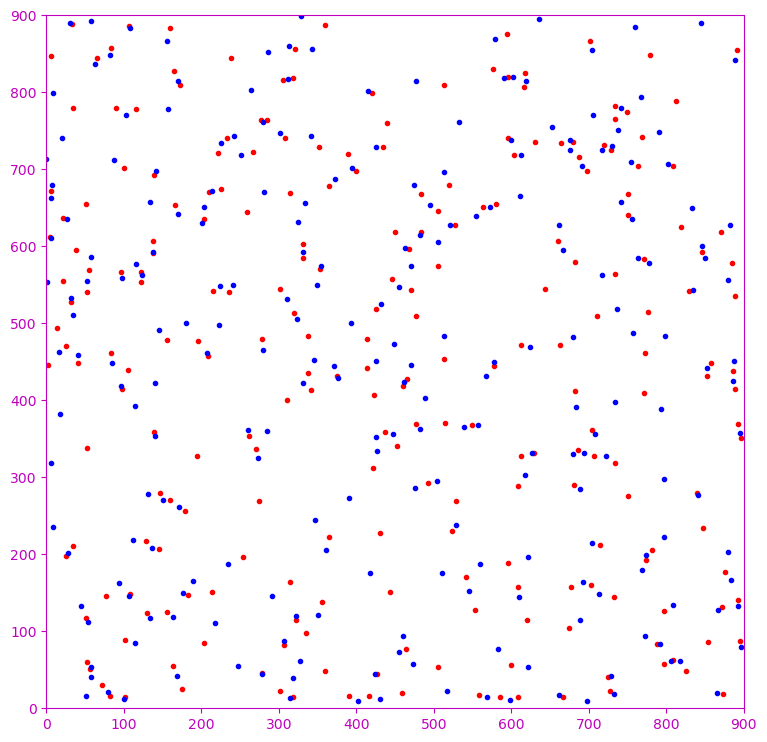

In [132]:
%matplotlib inline
import matplotlib

matplotlib.rc('axes', edgecolor='m')
plt.rcParams['xtick.color'] = 'm'
plt.rcParams['ytick.color'] = 'm'

frames = minushalf_df["frame"].unique()
white_frame = np.ones_like(cv2.imread(image_list[0]))[:,900:,:]
[height, width, _] = white_frame.shape

fig, ax = plt.subplots(1,1, figsize=(width//100, height//100))
# ax.set_axis_off()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

for f_num,f in enumerate(frames):
    
    minushalf = minushalf_df[minushalf_df["frame"]==f]
    plushalf = plushalf_df[plushalf_df["frame"]==f]
    
    alpha_half, scale_half = .9, 40   
    ax.clear() 
    # ax.imshow(white_frame, "gray")
    ax.plot(plushalf['x'], plushalf['y'],'r.',markersize=6, alpha=1)
    # ax.quiver(plushalf['x'], plushalf['y'], 
    #     np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
    #     headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

    ax.plot(minushalf['x'], minushalf['y'],'b.',markersize=6, alpha=1)
    # for i in range(3):
    #     ax.quiver(minushalf['x'], minushalf['y'], 
    #         np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
    #         headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)  

    save_path = os.path.join(
        os.path.dirname(image_list[0]),
        'Defects',
        'Nematic2',
        'frame_' + str(f) + ".png"
        )
    # break
    ax.set_xlim([0, width])
    ax.set_ylim([0, height])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))

    progressBar(f_num, len(frames))
    # break

- (1) Compute trajectories with TrackMate
- (2) Combine TrackMate and Defect CSVs

In [133]:
(os.path.dirname(image_list[0]) + r"\Defects\PlusTM_spots.csv",
os.path.dirname(image_list[0]) + r"\Defects\PlusHalf1.csv")

('C:\\Users\\victo\\Downloads\\SB_lab\\BEER_DATA\\20X defect\\20 mix in red right panel\\Defects\\PlusTM_spots.csv',
 'C:\\Users\\victo\\Downloads\\SB_lab\\BEER_DATA\\20X defect\\20 mix in red right panel\\Defects\\PlusHalf1.csv')

In [135]:
minushalf_df = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\MinusHalf1.csv")
plushalf_df = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\PlusHalf1.csv")

minushalf_TM = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\MinusTM_spots.csv", skiprows=[1,2,3])
plushalf_TM = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\PlusTM_spots.csv", skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders
last_frame = minushalf_df["frame"].max() # Validate this number in image folders

print("  ////////    PLUS   //////////")
print([(plushalf_TM[plushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(plushalf_df[plushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

print("\n ////////    MINUS   //////////")
print([(minushalf_TM[minushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(minushalf_df[minushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

  ////////    PLUS   //////////
[(230, 20), (216, 20), (229, 20), (241, 20), (240, 20), (244, 20), (271, 20), (254, 20), (255, 20), (256, 20)]
[(235, 10), (221, 10), (234, 10), (248, 10), (248, 10), (253, 10), (280, 10), (260, 10), (266, 10), (259, 10)]

 ////////    MINUS   //////////
[(236, 20), (219, 20), (234, 20), (246, 20), (246, 20), (253, 20), (274, 20), (257, 20), (267, 20), (260, 20)]
[(236, 10), (219, 10), (234, 10), (246, 10), (246, 10), (253, 10), (274, 10), (257, 10), (267, 10), (260, 10)]


In [44]:
X.shape, y.shape, first_frame

((490,), (504,), 1)

slope: 1.2904281042653645 | intercept: -67.55296164369094
slope: 1.2904281042653645 | intercept: -67.55296164369094
slope: 1.2905044285928358 | intercept: -67.54075984569612
-------  X  ------------
slope: 1.2986736688022 | intercept: -66.24366214679162
slope: 1.2986736688022 | intercept: -66.24366214679162
slope: 1.2987319341337966 | intercept: -66.25949596684221
-------  Y  ------------


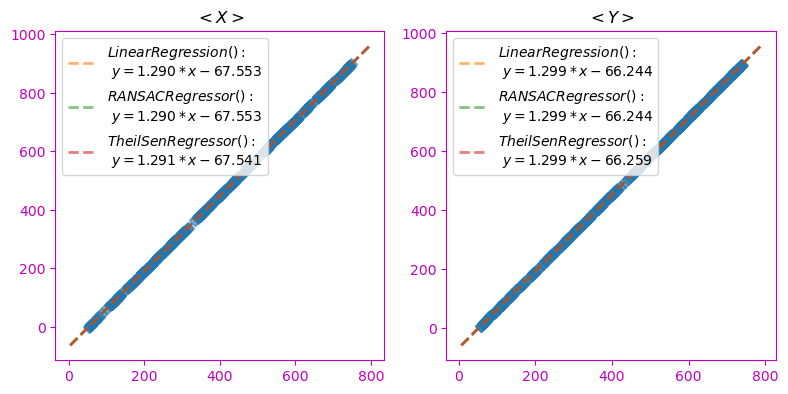

In [136]:
from sklearn import linear_model

%matplotlib inline
frame = 0

fig, axs = plt.subplots(1,2,  figsize=(8,16))

dims = ("x", "y")
lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

slope_intercept = {}

for ax,dd in zip(axs, dims):
    ave_slope, ave_intercept = 0, 0

    X = minushalf_TM["POSITION_"+dd.upper()][minushalf_TM["FRAME"]==frame].iloc[:].sort_values().values
    y = minushalf_df[dd][minushalf_df["frame"]==first_frame+frame].iloc[:]

    if dd=="y":
        # !!! insert image height (e.g. 900)
        y = (900 - y) # y- values are flipped
    y = y.sort_values().values

    ax.plot(X, y, "D", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # use prints to set the SLOPE and INTERCEP globals in the next cell
        print('slope:', slope, '| intercept:', intercept)

        # prdict for line
        line_X = np.arange(X.min()-50, X.max()+50)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x %.3f$" %(lr, slope, intercept))   
         
        ave_slope += slope  
        ave_intercept += intercept

    ax.set_title("$< %s >$" %dd.upper())

    ax.set_box_aspect(1)
    ax.legend(loc='upper left')
    print("-------  %s  ------------" %dd.upper())

    slope_intercept[dd] = {"slope": ave_slope/len(lrs),
                             "intercept": ave_intercept/len(lrs)
                             }

    # ave_slope = ave_slope/len(lrs)
    # ave_intercept = ave_intercept/len(lrs)
plt.tight_layout()

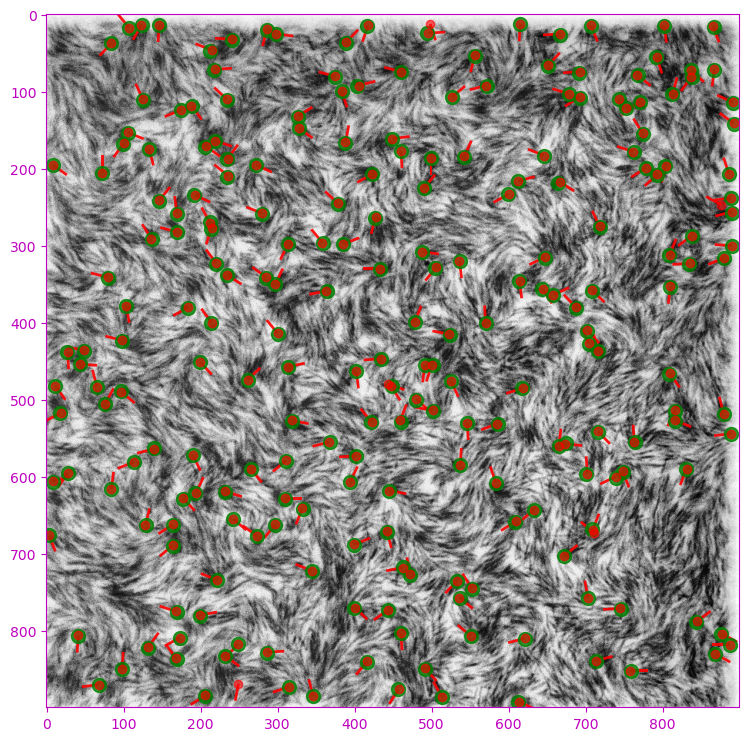

In [142]:
%matplotlib inline
SLOPEx = slope_intercept["x"]["slope"]
INTERCEPTx = slope_intercept["x"]["intercept"]
SLOPEy = slope_intercept["y"]["slope"]
INTERCEPTy = slope_intercept["y"]["intercept"]
frame = 0

# image_list_all = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps/*.tif")
# image_list_all = glob.glob(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\ISF defects new\6\*.tif")
# image_list_all = glob.glob(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\10X defect\10 mix in red right panel\*.tif")
image_list_all = glob.glob(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\20X defect\20 mix in red right panel\*.tif")
image_list = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[0]

plushalf_df = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\PlusHalf1.csv")
plushalf_TM = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\PlusTM_spots.csv", skiprows=[1,2,3])

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,900:,0]#[:,:,0]#
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(img1.shape[1]//100,img1.shape[0]//100))
ax.imshow(255-img_clahe, "gray")

x = plushalf_TM["POSITION_X"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEx + INTERCEPTx
y = h_img - (plushalf_TM["POSITION_Y"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEy + INTERCEPTy)
ax.plot(x, y,'go',markersize=10, alpha=.8)

alpha_half, scale_half = .9, 40  
p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6)
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

In [143]:
%matplotlib qt

minushalf_df = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\MinusHalf1.csv")
plushalf_df = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\PlusHalf1.csv")

minushalf_TM = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\MinusTM_spots.csv", skiprows=[1,2,3])
plushalf_TM = pd.read_csv(os.path.dirname(image_list[0]) + r"\Defects\PlusTM_spots.csv", skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders

plushalf_TM["x_img"] = plushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
plushalf_TM["y_img"] = h_img - (plushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)
minushalf_TM["x_img"] = minushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
minushalf_TM["y_img"] = h_img - (minushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)

# find same dots and check
dfs_TM = [plushalf_TM, minushalf_TM]
dfs_ori = [plushalf_df, minushalf_df]

for df_TM, df_ori in zip(dfs_TM, dfs_ori):
    xy_ori = np.array([df_ori["x"], df_ori["y"]]).T
    xy_TM = np.array([df_TM["x_img"].values, df_TM["y_img"].values]).T
    _,idx = center_pairs(
        xy_ori, #Long Array
        xy_TM #Short Array
        ) 
    # break
    print(xy_ori[idx[100:103]],'\n', xy_TM[100:103],'\n', df_ori[['x', 'y']].loc[idx[100:103]].values)
    print("--------------")

    # replace and add angles
    df_TM[['x_img1','y_img1','ang1','ang2','ang3','charge']] =  df_ori[['x', 'y','ang1','ang2','ang3','charge']].iloc[idx[:]].values


[[ 11. 482.]
 [ 65. 483.]
 [716. 436.]] 
 [[ 11.16877191 481.8364173 ]
 [ 65.36782083 483.13511039]
 [715.75640787 436.38215913]] 
 [[ 11. 482.]
 [ 65. 483.]
 [716. 436.]]
--------------
[[551. 732.]
 [466. 722.]
 [710. 749.]] 
 [[550.57835402 732.48418378]
 [465.40842    722.09463906]
 [710.59459368 749.36719396]] 
 [[551. 732.]
 [466. 722.]
 [710. 749.]]
--------------


In [145]:
# test replaced values
%matplotlib qt
frame = 50

# image_list_all = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps/*.tif")
# image_list_all = glob.glob(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\ISF defects new\6\*.tif")
# image_list_all = glob.glob(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\10X defect\10 mix in red right panel\*.tif")
image_list_all = glob.glob(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\20X defect\20 mix in red right panel\*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[frame]

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,900:,0]# [:,:,0]#
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(img1.shape[1]//100,img1.shape[0]//100))
ax.imshow(255-img_clahe, "gray")

# +1/2
idx = plushalf_TM["FRAME"]==frame
ax.plot(plushalf_TM["x_img1"][idx],
        plushalf_TM["y_img1"][idx],'go',
        markersize=10, alpha=.8, label="TrackMate table")
ax.quiver(plushalf_TM['x_img1'][idx], plushalf_TM['y_img1'][idx], 
    np.cos(plushalf_TM['ang1'][idx]), -np.sin(plushalf_TM['ang1'][idx]), 
    headaxislength=0, headwidth=0, headlength=0, color='g', scale=35, alpha=.8)        

p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6, label="detected from orientation")
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=40, alpha=.8)

# -1/2
idx = minushalf_TM["FRAME"]==frame
ax.plot(minushalf_TM["x_img1"][idx],
        minushalf_TM["y_img1"][idx],'bo',
        markersize=10, alpha=.8, label="TrackMate table")
for i in range(3):
    ax.quiver(minushalf_TM["x_img1"][idx], minushalf_TM["y_img1"][idx], 
        np.cos(minushalf_TM['ang'+str(i+1)][idx]), -np.sin(minushalf_TM['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='b', scale=35, alpha=.6)    

m_df =  minushalf_df[minushalf_df["frame"]==first_frame+frame]
ax.plot(m_df['x'], m_df['y'],'mo',markersize=6, alpha=.6, label="detected from orientation")
for i in range(3):
    ax.quiver(m_df["x"][idx], m_df["y"][idx], 
        np.cos(m_df['ang'+str(i+1)][idx]), -np.sin(m_df['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='m', scale=45, alpha=.6)    

ax.legend(loc='upper right', fontsize=14)

In [140]:
os.path.dirname(image_list[0]) + r"\Defects\PlusAndMinusTM.csv"

'C:\\Users\\victo\\Downloads\\SB_lab\\BEER_DATA\\10X defect\\10 mix in red right panel\\Defects\\PlusAndMinusTM.csv'

In [146]:
# Join TrackMate tabels for +1/2 and -1/2
pd.concat([plushalf_TM, minushalf_TM]).to_csv(os.path.dirname(image_list[0]) + r"\Defects\PlusAndMinusTM.csv")

# Start Here Find Pairs

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean, circstd, sem
import os
import sys
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import sys,time,random

sys.path.append('../defect_functions') 
from defect_pairs import * 
from average_flows import *  

import matplotlib

matplotlib.rc('axes', edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

# plus_minus_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects/PlusAndMinusTM.csv")
plus_minus_df = pd.read_csv(r'C:\Users\victo\Downloads\SB_lab\BEER_DATA\ISF defects new\6\Defects\PlusAndMinusTM.csv')
# plus_minus_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\10X defect\10 mix in red right panel\Defects\PlusAndMinusTM.csv")
# plus_minus_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\20X defect\20 mix in red right panel\Defects\PlusAndMinusTM.csv")
plus_minus_df.head()

Unnamed: 0    LABEL     ID  TRACK_ID    QUALITY  POSITION_X  POSITION_Y  \
0           0  ID84543  84543       NaN  73.665619       987.0        36.0   
1           1  ID84545  84545       0.0  81.421524        82.0        44.0   
2           2  ID84544  84544       1.0  81.146553       518.0        41.0   
3           3  ID84547  84547       2.0  81.421524       440.0        47.0   
4           4  ID84546  84546       3.0  81.421516       561.0        46.0   

   POSITION_Z  POSITION_T  FRAME  ...  CONTRAST_CH1   SNR_CH1        x_img  \
0         0.0         0.0      0  ...      0.902819  1.316414  1775.134982   
1         0.0         0.0      0  ...      0.973672  1.625018    23.677968   
2         0.0         0.0      0  ...      0.971355  1.623056   867.473834   
3         0.0         0.0      0  ...      0.973672  1.625018   716.519528   
4         0.0         0.0      0  ...      0.973672  1.625018   950.692233   

        y_img  x_img1  y_img1      ang1  ang2  ang3  charge  
0  896.827498  1776.0   896.0 -2.764602   NaN   NaN     0.5  
1  881.240928    23.0   881.0 -0.062832   NaN   NaN     0.5  
2  887.085892   867.0   887.0 -1.633628   NaN   NaN     0.5  
3  875.395964   716.0   875.0 -0.062832   NaN   NaN     0.5  
4  877.344285   951.0   877.0  1.507964   NaN   NaN     0.5  

[5 rows x 29 columns]

In [2]:
%matplotlib inline

msd_plus_dfL = msd_from_df(plus_minus_df[(plus_minus_df.charge==.5)&(plus_minus_df.x_img<900)],"x_img1","x_img1","FRAME","TRACK_ID")
msd_minus_dfL = msd_from_df(plus_minus_df[(plus_minus_df.charge==-.5)&(plus_minus_df.x_img<900)],"x_img1","x_img1","FRAME","TRACK_ID")
# msd_plus_dfR = msd_from_df(plus_minus_df[(plus_minus_df.charge==.5)&(plus_minus_df.x_img>900)],"x_img1","x_img1","FRAME","TRACK_ID")
# msd_minus_dfR = msd_from_df(plus_minus_df[(plus_minus_df.charge==-.5)&(plus_minus_df.x_img>900)],"x_img1","x_img1","FRAME","TRACK_ID")

# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

In [3]:
fig, ax2 = plt.subplots(1,1, figsize=(5,5))
win = 1

# for msd_df,color in zip([msd_plus_dfL, msd_minus_dfL,msd_plus_dfR, msd_minus_dfR], ["r","r","g","g"]):
for msd_df,color in zip([msd_plus_dfL, msd_minus_dfL], ["r","r"]):

    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax2.plot(msd_df.FRAME, msd_df["ave"], "-", color=color, alpha=.6, linewidth=3)
    ax2.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=color, alpha=.2) 

ax2.plot([0,0],[0,0], "-", color="r", linewidth=3, label=r"$+1/2 left$")
ax2.plot([0,0],[0,0], "-", color="r", linewidth=3, label=r"$-1/2 left$")
ax2.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$+1/2 right$")
ax2.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$-1/2 right$")

xref = np.arange(8, 15, 1)
ax2.plot(xref, 4e1*xref**2, "--k", xref, 3e2*xref**1, "--k",)
ax2.text(xref[0], 4e1*xref[-1]**2, r"$exp=2$", )
ax2.text(xref[-1], 3e2*xref[-1]**1, r"$exp=1$")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel(r"$Time ~()$", fontsize=14); ax2.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()
# plt.xlim([1,100]);plt.ylim([1e2,1e5])

In [4]:
from scipy import spatial
def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    tree = spatial.KDTree(Xlong)
    return tree.query(Xshort)   

pairs = []

plus_minus_df["FRAME"].unique()[-1]
for frame in plus_minus_df["FRAME"].unique()[:]:
    # print(frame)
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    dist, idx = center_pairs(minus_xy[["x_img1","y_img1"]], plus_xy[["x_img1","y_img1"]])
    # set a distance that define that defects are a pair (50)
    dist_tresh = dist<30
    # Notice: some TRACK_IDs are nan, meaning that they are not a part from any trajectory
    pairs.append([
        minus_xy["TRACK_ID"].iloc[idx][dist_tresh].values,#.astype(np.int_), 
        plus_xy["TRACK_ID"][dist_tresh].values,#.astype(np.intc)
        dist[dist_tresh]
        ]) 

# pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus"]).dropna().drop_duplicates()    
pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus","dist"]).dropna().drop_duplicates()
_, indices = np.unique(pairs_df["minus"], return_index=True)
pairs_df = pairs_df.iloc[indices].copy()

In [5]:
%matplotlib qt

def equlalize_trajectories(plus_minus_df, p_idx, m_idx):
    ''' makes sure that positive (p_idx) and negative (m_idx) defect trajectory are equal
    according to "FRAME" number
    if missing frame for one of them it removed with dropna()
    '''
    df1 = plus_minus_df[["TRACK_ID","FRAME","x_img1","y_img1","ang1"]][p_idx]
    df1.set_index('FRAME', inplace=True)
    df2 =  plus_minus_df[["TRACK_ID","FRAME", "x_img1","y_img1", "ang1","ang2","ang3" ]][m_idx]
    df2.set_index('FRAME', inplace=True)
    df_ = pd.concat([df1, df2], axis=1).dropna()
    return df_.set_axis(["plus_id","xp","yp","angp1", "min_id","xm","ym", "angm1","angm2","angm3"], axis=1)

minimal_track = 5
PLOT = False

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_box_aspect(1)
plt.set_cmap('plasma')
count = 0
mp_distance = []
mp_distance_fusion = []
mp_distance_creation = []
pair_stat = []
all_pairs_df = []
fusion_TF = 1
for (num,m), n in zip(enumerate(pairs_df["minus"]), pairs_df["plus"]):
    m_idx = np.logical_and(plus_minus_df["TRACK_ID"]==m, plus_minus_df["charge"]==-.5)
    p_idx = np.logical_and(plus_minus_df["TRACK_ID"]==n, plus_minus_df["charge"]==.5)
    # minimal track length (20 frames)
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:

        count +=1
        dff_ = equlalize_trajectories(plus_minus_df, p_idx, m_idx)
        all_pairs_df.append(dff_)
        # "xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" 
        xm, ym = dff_["xm"].values, dff_["ym"].values
        xp, yp = dff_["xp"].values, dff_["yp"].values
        thm = np.array((
            dff_["angm1"].values, 
            dff_["angm2"].values,
            dff_["angm3"].values
        ))
        thp = dff_["angp1"].values
        # thp[thp<0] = thp[thp<0] + 2*np.pi 

        pair_distance = ((xm-xp)**2 + (ym-yp)**2)**.5
        mp_distance.append(pair_distance)
        
        # if distance decrease = fusion
        fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
        if fusion:
            fusion_TF = 1
            mp_distance_fusion.append(pair_distance)
        else:
            fusion_TF = -1
            mp_distance_creation.append(pair_distance)
        
        # angle btw defect centers
        mp_angle = np.arctan2(ym-yp, xm-xp) 
        mp_angle[mp_angle<0] = mp_angle[mp_angle<0] + 2*np.pi
        
        # displacment angle of =1/2 defect
        p_vel_angle = np.arctan2(np.diff(yp), np.diff(xp)) 
        p_vel_angle[p_vel_angle<0] = p_vel_angle[p_vel_angle<0] + 2*np.pi

        diff_thm = (thm - thp).T
        diff_thm[diff_thm<0] = diff_thm[diff_thm<0] + 2*np.pi
        
        thm_min = np.min(np.abs(diff_thm), axis=1) + thp
        thm_min[thm_min<0] = thm_min[thm_min<0] + 2*np.pi
        pair_stat.append([thp-circmean(mp_angle), #np.median(mp_angle)
                          thm-circmean(mp_angle), 
                          p_vel_angle-circmean(mp_angle), 
                          (thp[:1]-p_vel_angle)%(2*np.pi),
                          fusion_TF * pair_distance # negative distance is creation
                        ])

        if PLOT:
            for i in range(3):
                ax.quiver(xm, ym, np.cos(thm[i]), np.sin(thm[i]),color="b", alpha=.3, scale=40)

            ax.quiver(xp, yp, np.cos(thp), np.sin(thp),color="r", alpha=.2)
            ax.quiver(xm, ym, np.cos(thm_min), np.sin(thm_min),color="m", alpha=.3, scale=40)

            ax.quiver(xp[-1], yp[-1], np.cos(thp[-1]), np.sin(thp[-1]),color="r", alpha=.6, scale=15)
            ax.quiver(xm[-1], ym[-1], np.cos(thm_min[-1]), np.sin(thm_min[-1]),color="b", alpha=.6, scale=15)

            ax.scatter(xm, ym, c=np.arange(len(xm)), s=40, alpha=.8)
            ax.scatter(xp, yp, c=np.arange(len(xp)), s=40, alpha=.8)
            # ax.text(xp[-1]-10, yp[-1]+10, str((thp[-1]*180/np.pi)//1), fontsize=20)
            ax.text(xp[-1], yp[-1], "%s" %str(((thp[-1]-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
            ax.text(xm[-1], ym[-1], "%s" %str(((thm.min()-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
    
    progressBar(num, len(pairs_df))

all_pairs_df = pd.concat(all_pairs_df)

# all_pairs_df.to_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\all_Pairs.csv")

C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_37124\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
# pair_stat.append([thp-circmean(mp_angle), #np.median(mp_angle)
#                     thm-circmean(mp_angle), 
#                     p_vel_angle-circmean(mp_angle), 
#                     (thp[:1]-p_vel_angle)%(2*np.pi),
#                     pair_distance
#                 ])
df = pd.DataFrame(data={
    "p_ang": np.concatenate([p[0] for p in pair_stat]), 
    "m_ang1": np.concatenate([p[1][0] for p in pair_stat]),
    "m_ang2": np.concatenate([p[1][1] for p in pair_stat]), 
    "m_ang3": np.concatenate([p[1][2] for p in pair_stat]), 
    # "p_vel_angle": np.concatenate([p[2] for p in pair_stat]), 
    # "X": np.concatenate(pair_stat)[:,3], 
    "distance": np.concatenate([pair[4] for pair in pair_stat]), 
    }).dropna()


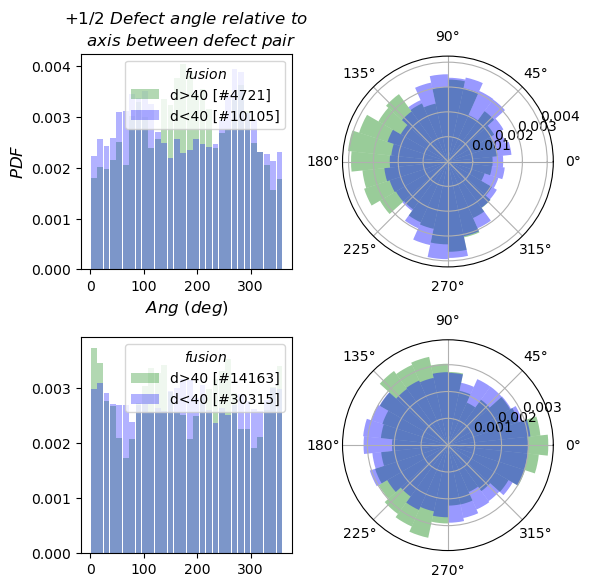

In [39]:
%matplotlib inline
dist = 40
bins_number = 30  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
width = 2 * np.pi / bins_number

fig3 = plt.figure(figsize=(6,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222, projection='polar')
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection='polar')
ax1.set_ylabel("$PDF$", fontsize=12)
ax1.set_xlabel("$Ang~(deg)$", fontsize=12)

df_f = df[df["distance"]>0].copy()
df_cr = df[df["distance"]<0].copy()

# df1 = df_f[np.logical_and(
#                     df_f["distance"]>40, 
#                     df_f["distance"]<60,
#                    )].copy()

df1 = df_f.copy()
df1["distance"] = df1["distance"].abs()

m_ang_close, m_ang_far, m_ang_all = [], [], []
for i in range(3):
    m_ang_close.append(df1["m_ang"+str(i+1)][df1["distance"]<dist].values)
    m_ang_far.append(df1["m_ang"+str(i+1)][df1["distance"]>dist].values)
    m_ang_all.append(df1["m_ang"+str(i+1)].values)
    # break
m_ang_close = np.concatenate(m_ang_close)
m_ang_far = np.concatenate(m_ang_far)
m_ang_all = np.concatenate(m_ang_all)  

# p0,_,_ = ax3.hist((m_ang_all % (2*np.pi))*180/np.pi, bins*180/np.pi, 
#                     density=True, rwidth=.9, alpha=.3, color="red",
#                     label="all [#%s]" %(len(m_ang_all))
#                     )
# ax4.bar(bins[:bins_number], p0, width=width, bottom=0.0, alpha=.4, color="red")

p0,_,_ = ax3.hist((m_ang_far % (2*np.pi))*180/np.pi, bins*180/np.pi, 
                    density=True, rwidth=.9, alpha=.3, color="green",
                    label="d>%s [#%s]" %(dist, len(m_ang_far))
                    )
ax4.bar(bins[:bins_number], p0, width=width, bottom=0.0, alpha=.4, color="green")
p0,_,_ = ax3.hist((m_ang_close % (2*np.pi))*180/np.pi, bins*180/np.pi, 
                    density=True, rwidth=.9, alpha=.3, color="blue",
                    label="d<%s [#%s]" %(dist, len(m_ang_close))
                    )
ax4.bar(bins[:bins_number], p0, width=width, bottom=0.0, alpha=.4, color="blue")

# p0,_,_ = ax1.hist((df1["p_ang"] % (2*np.pi))*180/np.pi, bins*180/np.pi, 
#                   density=True, rwidth=.9, alpha=.3, color="red",
#                   label="all [#%s]" %(len(df1["p_ang"]))
#                   )
# ax2.bar(bins[:bins_number], p0, color="red", width=width, bottom=0.0, alpha=.5)

p1,_,_ = ax1.hist((df1["p_ang"][df1["distance"]>dist] % (2*np.pi))*180/np.pi, bins*180/np.pi, 
                  density=True, rwidth=.9, alpha=.3, color="green",
                  label="d>%s [#%s]" %(dist, len(df1["p_ang"][df1["distance"]>dist]))
                  )
ax2.bar(bins[:bins_number], p1, color="green", width=width, bottom=0.0, alpha=.4)

p2,_,_ = ax1.hist((df1["p_ang"][df1["distance"]<dist] % (2*np.pi))*180/np.pi, bins*180/np.pi,
                   density=True, rwidth=.9, alpha=.3, color="blue",
                   label="d<%s [#%s]" %(dist, len(df1["p_ang"][df1["distance"]<dist]))
                   )
ax2.bar(bins[:bins_number], p2, color="blue", width=width, bottom=0.0, alpha=.4)

ax1.legend(loc='upper right')
ax1.get_legend().set_title("$fusion$")
ax1.set_title("$+1/2 ~Defect ~angle ~relative ~to$\n $ ~axis ~between ~defect ~pair$")

ax3.legend(loc='best')
ax3.get_legend().set_title("$fusion$")
plt.tight_layout()

In [37]:
np.median(df_f["distance"]), -np.median(df_cr["distance"])

(29.966648127543394, 39.6232255123179)

Median vals. 29.966648127543394 39.6232255123179


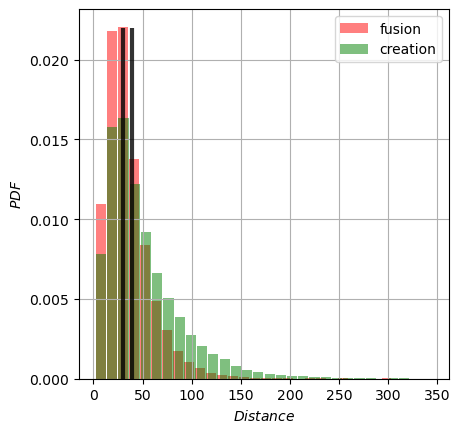

In [36]:
%matplotlib inline
ax = df_f["distance"].hist(bins=30, density=True, rwidth=.9, label="fusion", color="red", alpha=.5)
ax.vlines(np.median(df_f["distance"]), 0, .022, "k", linewidth=3, alpha=.8)
(-1* df_cr["distance"]).hist(bins=30, density=True, rwidth=.9, label="creation", color="green",alpha=.5)
ax.vlines(-np.median(df_cr["distance"]), 0, .022, "k", linewidth=3, alpha=.8)
ax.set_box_aspect(1)
ax.set_ylabel("$PDF$"); ax.set_xlabel("$Distance$")
ax.legend(loc='upper right')
print("Median vals.", np.median(df_f["distance"]), -np.median(df_cr["distance"]))

In [40]:
''' -- ADD ---
1) distance btw pairs 
2)angle btw + and - centers 
3) fusion/creation 
'''
all_pairs_df["distance"] = (
    (all_pairs_df["xm"]-all_pairs_df["xp"])**2 + (all_pairs_df["ym"]-all_pairs_df["yp"])**2
    )**.5

all_pairs_df["mp_angle"] = np.arctan2(all_pairs_df["ym"]-all_pairs_df["yp"], 
                                      all_pairs_df["xm"]-all_pairs_df["xp"]) % (2*np.pi)

grouped = all_pairs_df.groupby('min_id')["distance"]
all_pairs_df["fusion"] = grouped.transform(lambda x: x[:len(x)//2].mean()>x[len(x)//2:].mean())

C:\Users\victo\AppData\Local\Temp\ipykernel_37124\3381741901.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  all_pairs_df["fusion"] = grouped.transform(lambda x: x[:len(x)//2].mean()>x[len(x)//2:].mean())


In [41]:
fuse_df = all_pairs_df[all_pairs_df["fusion"]]
fuse_df["angp1_rel"] = (fuse_df["angp1"] - fuse_df["mp_angle"]) % (2*np.pi)
for i in range(3):
    fuse_df["angm"+str(i+1)+"_rel"] = (fuse_df["angm"+str(i+1)] - fuse_df["mp_angle"]) % (2*np.pi)

grouped = fuse_df.groupby('plus_id')["angp1_rel"]
fuse_df["fuse_up"] = grouped.transform(lambda x: circmean(x)>np.pi)

create_df = all_pairs_df.loc[~all_pairs_df["fusion"]]
create_df["angp1_rel"] = (create_df["angp1"] - create_df["mp_angle"]) % (2*np.pi)

In [51]:
%matplotlib inline
dist = 40
m_ang_up_close, m_ang_down_close = [], []
m_ang_up_far, m_ang_down_far = [], []
for i in range(3):
    m_ang_up_close.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        fuse_df["fuse_up"], fuse_df["distance"]<dist)].values)
    m_ang_down_close.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        ~fuse_df["fuse_up"], fuse_df["distance"]<dist)].values)
    m_ang_up_far.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        fuse_df["fuse_up"], fuse_df["distance"]>dist)].values)
    m_ang_down_far.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        ~fuse_df["fuse_up"], fuse_df["distance"]>dist)].values)
    # break
    
m_ang_up_close = np.concatenate(m_ang_up_close) 
m_ang_down_close = np.concatenate(m_ang_down_close) 
m_ang_up_far = np.concatenate(m_ang_up_far) 
m_ang_down_far = np.concatenate(m_ang_down_far) 

fig1 = plt.figure(figsize=(6,7))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222, projection='polar')
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection='polar')

# p1,_,_ = ax1.hist((m_ang_up_close % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p1,_,_ = ax1.hist((m_ang_up_close % (2*np.pi))*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="b")

# p2,_,_ = ax1.hist(360-(-m_ang_down_close % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p2,_,_ = ax1.hist((m_ang_down_close % (2*np.pi))*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="g")

ax2.bar(bins[:bins_number], p1, color="green", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} > \pi$")
ax2.bar(bins[:bins_number], p2, color="blue", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} < \pi$")
ax2.legend(bbox_to_anchor=(1.2, 1.1)); ax2.set_title("dist<%s" % dist)

# p3,_,_ = ax3.hist((m_ang_up_far % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p3,_,_ = ax3.hist((m_ang_up_far % (2*np.pi))*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="b")

# p4,_,_ = ax3.hist(360-(-m_ang_down_far % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p4,_,_ = ax3.hist(m_ang_down_far % (2*np.pi)*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="g")

ax4.bar(bins[:bins_number], p3, color="green", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} > \pi$")
ax4.bar(bins[:bins_number], p4, color="blue", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} < \pi$")
ax4.legend(bbox_to_anchor=(1.2, 1.1)); ax4.set_title("dist>%s" % dist)


Text(0.5, 1.0, 'dist>40')

Text(0, 0.5, '$Angle$')

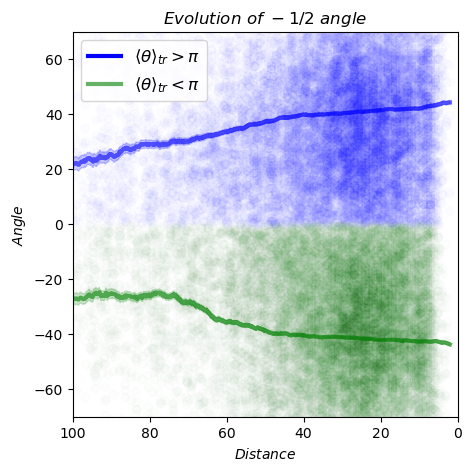

In [44]:
%matplotlib inline                 

df_all = fuse_df
win = 15

fig, ax1 = plt.subplots(1,1,  figsize=(5,5))

for i in range(3):
    y_up = df_all["angm"+str(i+1)+"_rel"][fuse_df["fuse_up"]] % (2/3*np.pi)
    y_down = df_all["angm"+str(i+1)+"_rel"][~fuse_df["fuse_up"]] % (2/3*np.pi)
    ax1.plot(df_all.distance[fuse_df["fuse_up"]], y_up*180/np.pi, "ob", alpha=.01)
    ax1.plot(df_all.distance[~fuse_df["fuse_up"]], -120+(y_down*180/np.pi), "og", alpha=.01)

m_ang_all = []
for i in range(3):
    m_ang_all.append(fuse_df["angm"+str(i+1)+"_rel"].values)
    # break
    
df_all["angm_rel_all"] = circmean(np.array(m_ang_all) % (2/3*np.pi), axis=0) % (2/3*np.pi)

df = df_all[fuse_df["fuse_up"]]
df_av_up = plot_rolling_average(df, ax1, "angm_rel_all", "distance", win=win, color="b", high=2/3*np.pi)
ax1.plot([0,0],[0,0], "-b", linewidth=3, label=r"$\langle \theta \rangle _{tr} > \pi$")
      

df = df_all[~fuse_df["fuse_up"]]
df_av_down = plot_rolling_average(df, ax1, "angm_rel_all", "distance", show=False, win=win, color="g", high=2/3*np.pi)
# flip to negative values to show divergence
ax1.plot(df_av_down["distance"], -120+df_av_down["angm_rel_all_ave"], "-", color="g", alpha=.6, linewidth=3,
         label=r"$\langle \theta \rangle _{tr} < \pi$")
ax1.fill_between(df_av_down.distance, 
                 (-120+df_av_down["angm_rel_all_ave"])-df_av_down["angm_rel_all_std"]/df_av_down["angm_rel_all_count"]**.5, 
                 (-120+df_av_down["angm_rel_all_ave"])+df_av_down["angm_rel_all_std"]/df_av_down["angm_rel_all_count"]**.5, 
                 color="g", alpha=.2)

plt.xlim([0,100]); 
plt.ylim([-70,70]); 
# plt.yticks(np.arange(-60, 61, 30))
plt.gca().set_box_aspect(1); plt.gca().invert_xaxis()
plt.legend(fontsize=12); plt.title("$Evolution ~of ~-1/2 ~angle$")
plt.xlabel("$Distance$"); plt.ylabel("$Angle$")    

In [45]:
low,high = 40, 50
np.mean(df_av_down[(df_av_down.distance<high)&(df_av_down.distance>low)]), 25/1000**.5

c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(distance                44.454746
 angm_rel_all_ave        80.044337
 angm_rel_all_std        27.749887
 angm_rel_all_count    3528.615668
 dtype: float64,
 0.7905694150420949)

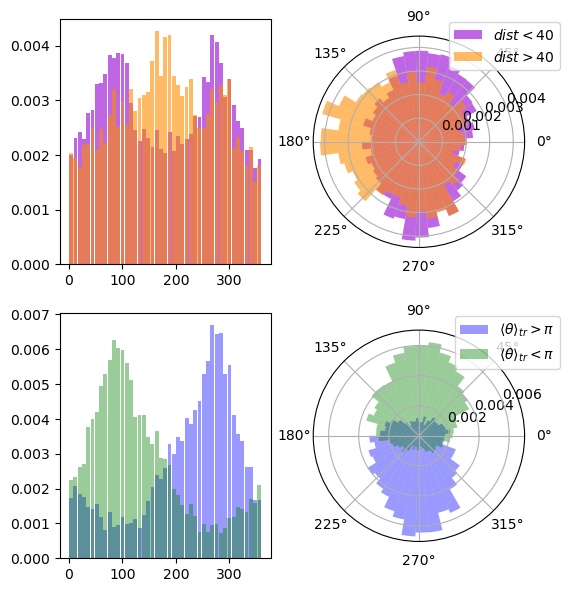

In [47]:
%matplotlib inline
dist = 40
bins_number = 45  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1)
width = 2 * np.pi / bins_number

y = (fuse_df["angp1_rel"]) % (2*np.pi)
y_close = (fuse_df["angp1_rel"][fuse_df["distance"]<dist]) % (2*np.pi)
y_far = (fuse_df["angp1_rel"][fuse_df["distance"]>dist]) % (2*np.pi)
y_up = (fuse_df["angp1_rel"][fuse_df["fuse_up"]]) % (2*np.pi)
y_down = (fuse_df["angp1_rel"][~fuse_df["fuse_up"]]) % (2*np.pi)

plt.figure(figsize=(6,7))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222, projection='polar')
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection='polar')

# p = ax1.hist(y, 60, alpha=.3, density=True, rwidth=.9)
p1,_,_ = ax1.hist(y_close*180/np.pi, 45, alpha=.6, density=True, rwidth=.9, color="darkviolet")
p2,_,_ = ax1.hist(y_far*180/np.pi, 45, alpha=.6, density=True, rwidth=.9, color="darkorange")
p3,_,_ = ax3.hist(y_up*180/np.pi, 45, alpha=.4, density=True, rwidth=.9, color="b")
p4,_,_ = ax3.hist(y_down*180/np.pi, 45, alpha=.4, density=True, rwidth=.9, color="g")


ax2.bar(bins[:bins_number], p1, color="darkviolet", width=width, bottom=0., alpha=.6, label="$dist<%s$" %dist)
ax2.bar(bins[:bins_number], p2, color="darkorange", width=width, bottom=0., alpha=.6, label="$dist>%s$" %dist)
ax4.bar(bins[:bins_number], p3, color="b", width=width, bottom=0., alpha=.4, label=r"$\langle \theta \rangle _{tr} > \pi$")
ax4.bar(bins[:bins_number], p4, color="g", width=width, bottom=0., alpha=.4, label=r"$\langle \theta \rangle _{tr} < \pi$")
ax2.legend(bbox_to_anchor=(1.2, 1.1)); ax4.legend(bbox_to_anchor=(1.2, 1.1))

Text(0, 0.5, '$Angle$')

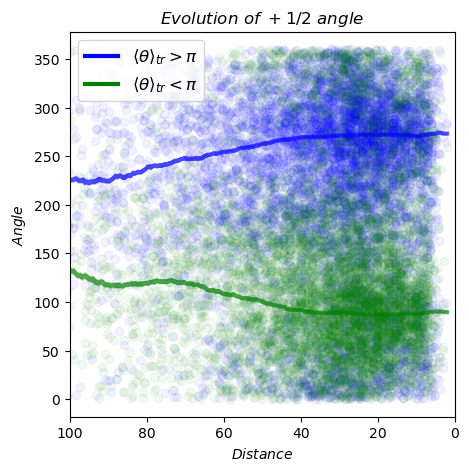

In [48]:
%matplotlib inline

df_all = fuse_df #create_df# 

fig, ax1 = plt.subplots(1,1,  figsize=(5,5))
ax1.plot(df_all.distance[fuse_df["fuse_up"]], df_all.angp1_rel[fuse_df["fuse_up"]]*180/np.pi, "ob", alpha=.05)
ax1.plot(df_all.distance[~fuse_df["fuse_up"]], df_all.angp1_rel[~fuse_df["fuse_up"]]*180/np.pi, "og", alpha=.05)


win = 15

df = df_all[fuse_df["fuse_up"]]
df_av_up = plot_rolling_average(df, ax1, "angp1_rel", "distance", win=win, color="b")
df = df_all[~fuse_df["fuse_up"]]
df_av_down = plot_rolling_average(df, ax1, "angp1_rel", "distance", win=win, color="g")
ax1.plot([0,0],[0,0], "-b", linewidth=3, label=r"$\langle \theta \rangle _{tr} > \pi$")
ax1.plot([0,0],[0,0], "-g", linewidth=3, label=r"$\langle \theta \rangle _{tr} < \pi$")


plt.xlim([0,100]); 
# plt.ylim([0,360]); 
# plt.yticks(np.arange(0, 361, 60))
plt.gca().set_box_aspect(1); plt.gca().invert_xaxis()
plt.legend(fontsize=12); plt.title("$Evolution ~of ~+1/2 ~angle$")
plt.xlabel("$Distance$"); plt.ylabel("$Angle$")

## Relative angle between defects in a pair

Text(0.5, 1.0, '$Relative ~angle ~btw ~-1/2 ~and ~+1/2 ~defects$')

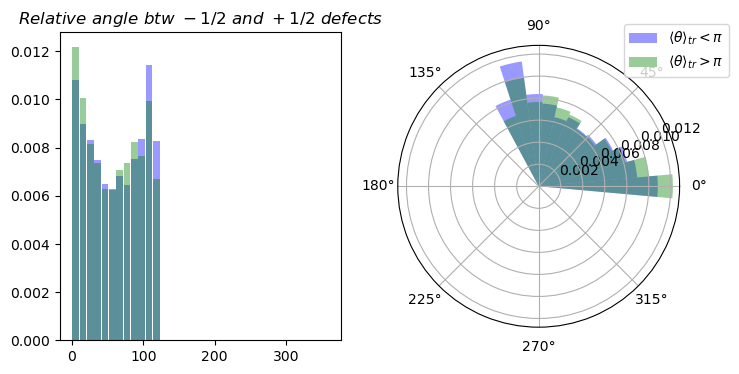

In [58]:
fig1 = plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
bins_number = 35  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1) #* 180/np.pi
width = 2 * np.pi / bins_number

m_ang_all = []
for i in range(3):
    fuse_df["mp_angle"+str(i+1)]  = (fuse_df["angm"+str(i+1)] - fuse_df.angp1) % (2*np.pi)

mp_ang = []
mp_ang_up = []
mp_ang_down = []
for i in range(3):
    mp_ang.append(fuse_df["mp_angle"+str(i+1)].values)
    mp_ang_up.append(fuse_df["mp_angle"+str(i+1)][fuse_df.fuse_up].values)
    mp_ang_down.append(fuse_df["mp_angle"+str(i+1)][~fuse_df.fuse_up].values)   

mp_ang_up = np.array(mp_ang_up)
mp_ang_down = np.array(mp_ang_down)
fuse_df["mp_angle_av"]= circmean(mp_ang, axis=0, low=0, high=2/3*np.pi)

# p1,_,_ = ax1.hist(mp_ang_up.ravel() *180/np.pi, bins*180/np.pi, # 3 peaks
p1,_,_ = ax1.hist(fuse_df["mp_angle_av"][fuse_df.fuse_up] *180/np.pi, bins*180/np.pi, # one peak
    alpha=.4, rwidth=.9, density=True, color="b")# ,  df.shape  
ax2.bar(bins[:bins_number], p1, color="b", width=width, bottom=0.0, alpha=.4,
    label=r"$\langle \theta \rangle _{tr} < \pi$")

# p2,_,_ = ax1.hist(mp_ang_down.ravel() *180/np.pi, bins*180/np.pi, # 3 peaks
p2,_,_ = ax1.hist(fuse_df["mp_angle_av"][~fuse_df.fuse_up] *180/np.pi, bins*180/np.pi, # one peak
    alpha=.4, rwidth=.9, density=True, color="g")# ,  df.shape  
ax2.bar(bins[:bins_number], p2, color="g", width=width, bottom=0.0, alpha=.4,
    label=r"$\langle \theta \rangle _{tr} > \pi$")

ax2.legend(bbox_to_anchor=(1.2, 1.1)); ax1.set_title(r"$Relative ~angle ~btw ~-1/2 ~and ~+1/2 ~defects$")

Text(0, 0.5, '$Angle ~(deg)$')

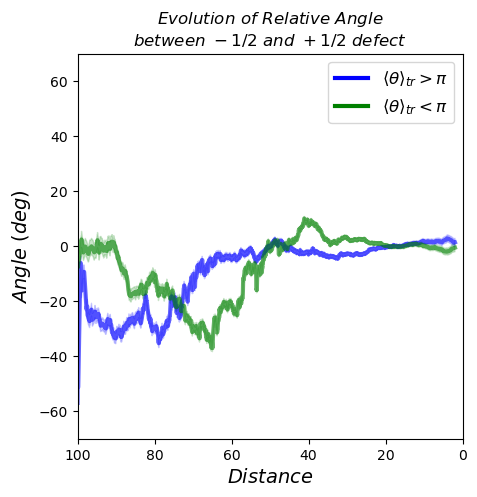

In [18]:
fig, ax1 = plt.subplots(1,1,  figsize=(5,5))

win = 11
# for i in range(3):
    # df_av_up = plot_rolling_average(fuse_df[fuse_df.fuse_up], ax1, "mp_angle"+str(i+1), "distance", win=win, color="b", low=-2/3*np.pi, high=0)
    # df_av_up = plot_rolling_average(fuse_df[~fuse_df.fuse_up], ax1, "mp_angle"+str(i+1), "distance", win=win, color="g", low=0*np.pi, high=2/3*np.pi)


# ax1.plot(df_all.distance[fuse_df.fuse_up], (df_all.mp_angle_av[fuse_df.fuse_up] % (2/3*np.pi) - (1/3*np.pi))*180/np.pi, "ob", alpha=.05)
# ax1.plot(df_all.distance[~fuse_df.fuse_up], (df_all.mp_angle_av[~fuse_df.fuse_up] % (2/3*np.pi) - (1/3*np.pi))*180/np.pi, "og", alpha=.05)

df_av_up = plot_rolling_average(fuse_df[fuse_df.fuse_up], ax1, "mp_angle_av", "distance", win=win, color="b", low=-1/3*np.pi, high=1/3*np.pi)
df_av_up = plot_rolling_average(fuse_df[~fuse_df.fuse_up], ax1, "mp_angle_av", "distance", win=win, color="g", low=-1/3*np.pi, high=1/3*np.pi)

ax1.plot([0,0],[0,0], "-b", linewidth=3, label=r"$\langle \theta \rangle _{tr} > \pi$")
ax1.plot([0,0],[0,0], "-g", linewidth=3, label=r"$\langle \theta \rangle _{tr} < \pi$")


plt.xlim([100,0]); plt.ylim([-70, 70]); #plt.yticks(np.arange(0, 121, 30))
plt.gca().set_box_aspect(1); #plt.gca().invert_xaxis()  
plt.legend(fontsize=12); 
plt.title(r"$Evolution ~of ~Relative ~Angle$" +"\n" + r"$between ~-1/2 ~and ~+1/2 ~defect$")
plt.xlabel(r"$Distance$", fontsize=14); plt.ylabel(r"$Angle ~(deg)$", fontsize=14)    

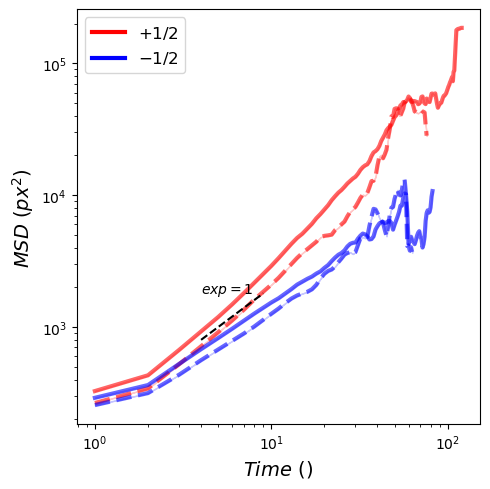

In [19]:
min_dist, max_dist = 40, 40
min_track = 1

# msd_plus_df_far = msd_from_df(all_pairs_df[~all_pairs_df.fusion].reset_index(),"xp","yp","FRAME","plus_id",minimal_track=min_track)
# msd_minus_df_far = msd_from_df(all_pairs_df[~all_pairs_df.fusion].reset_index(),"xm","ym","FRAME","min_id",minimal_track=min_track)

# df = all_pairs_df[all_pairs_df.fusion]
# msd_plus_df_far = msd_from_df(df[df.distance>min_dist].reset_index(),"xp","yp","FRAME","plus_id",minimal_track=min_track)
# msd_minus_df_far = msd_from_df(df[df.distance>min_dist].reset_index(),"xm","ym","FRAME","min_id",minimal_track=min_track)
# msd_plus_df_close = msd_from_df(df[df.distance<max_dist].reset_index(),"xp","yp","FRAME","plus_id",minimal_track=min_track)
# msd_minus_df_close= msd_from_df(df[df.distance<max_dist].reset_index(),"xm","ym","FRAME","min_id",minimal_track=min_track)
# dfs = [msd_plus_df_far, msd_minus_df_far, msd_plus_df_close, msd_minus_df_close]

df = all_pairs_df[all_pairs_df.fusion]
plus_fuse = msd_from_df(df.reset_index(),"xp","yp","FRAME","plus_id",minimal_track=min_track)
minus_fuse = msd_from_df(df.reset_index(),"xm","ym","FRAME","min_id",minimal_track=min_track)

df = all_pairs_df[~all_pairs_df.fusion]
plus_cr = msd_from_df(df.reset_index(),"xp","yp","FRAME","plus_id",minimal_track=min_track)
minus_cr = msd_from_df(df.reset_index(),"xm","ym","FRAME","min_id",minimal_track=min_track)
dfs = [plus_fuse, minus_fuse, plus_cr, minus_cr]


%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1

colors = ["--r","--b", "-r", "-b"]

for msd_df,color in zip(dfs, colors):
    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax1.plot(msd_df.FRAME, msd_df["ave"], color, alpha=.6, linewidth=3)
    ax1.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=''.join(x for x in color if x.isalpha()), alpha=.2) 


ax1.plot([0,0],[0,0], "-", color="r", linewidth=3, label=r"$+1/2$")
ax1.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(4, 10, 1)
ax1.plot(xref, 2e2*xref**1,"--k")
ax1.text(xref[0], 2e2*xref[-1]**1, r"$exp=1$")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel(r"$Time ~()$", fontsize=14); ax1.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()


(0.033271686566742696, 6.262636769631233)

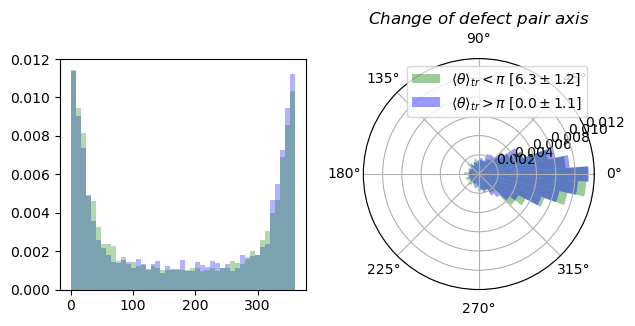

In [20]:
%matplotlib inline
diff_period = 2
dist = 30
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
width = 2 * np.pi / bins_number

# (df_all["mp_angle"][(df_all.fuse_up) & (df_all.distance<40)].diff() % 2*np.pi).hist(alpha=.6)
# (df_all["mp_angle"][~(df_all.fuse_up) & (df_all.distance<40)].diff() % 2*np.pi).hist(alpha=.6)

dtheta_up = df_all["mp_angle"][(df_all.fuse_up) & (df_all.distance<dist)].diff(periods=diff_period).dropna() % (2*np.pi)
dtheta_down = df_all["mp_angle"][(~df_all.fuse_up) & (df_all.distance<dist)].diff(periods=diff_period).dropna() % (2*np.pi)

fig1 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p1,_,_ = ax1.hist(dtheta_up*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=1., alpha=.3, color="b")
p2,_,_ = ax1.hist(dtheta_down*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=1., alpha=.3, color="g")

ax2.bar(bins[:bins_number], p1, color="green", width=width, bottom=0.0, alpha=.4,
        label=r"$\langle \theta \rangle _{tr} < \pi ~[%.1f  \pm%.1f]$" 
        %(circmean(dtheta_up), circstd(dtheta_up)))
ax2.bar(bins[:bins_number], p2, color="blue", width=width, bottom=0.0, alpha=.4,
        label=r"$\langle \theta \rangle _{tr} > \pi ~[%.1f  \pm%.1f]$" 
        %(circmean(dtheta_down), circstd(dtheta_down)))

ax2.legend(loc='upper right')
ax2.set_title(r"$Change ~of ~defect ~pair ~axis$")

circmean(dtheta_down, low=0, high=2*np.pi), circmean(dtheta_up, low=0, high=2*np.pi)

Text(0, 0.5, '$\\Delta \\theta, ~Angle ~change ~(deg)$')

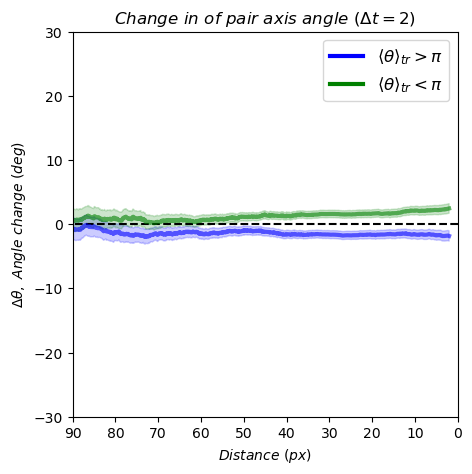

In [21]:
%matplotlib inline
win = 30
df = df_all.copy().set_index("distance")

dtheta_up = df["mp_angle"][df.fuse_up].diff(periods=diff_period).dropna()# % (2*np.pi)
dtheta_up = dtheta_up.reset_index()
dtheta_down = df["mp_angle"][~df.fuse_up].diff(periods=diff_period).dropna()
dtheta_down = dtheta_down.reset_index()

fig, ax1 = plt.subplots(1,1,  figsize=(5,5))
ax1.plot([0,160], [0,0], "--k", alpha=1)
# ax1.plot(dtheta_up.distance, (dtheta_up.mp_angle)*180/np.pi, "ob", alpha=.05)
# ax1.plot(dtheta_down.distance, (dtheta_down.mp_angle)*180/np.pi, "og", alpha=.05)

ax1.plot([0,0],[0,0], "-b", linewidth=3, label=r"$\langle \theta \rangle _{tr} > \pi$")
ax1.plot([0,0],[0,0], "-g", linewidth=3, label=r"$\langle \theta \rangle _{tr} < \pi$")

df_av_up = plot_rolling_average(dtheta_up, ax1, "mp_angle", "distance", win=win, color="b", low=-np.pi, high=np.pi)
df_av_down = plot_rolling_average(dtheta_down, ax1, "mp_angle", "distance", win=win, color="g", low=-np.pi, high=np.pi)

# ax1.invert_xaxis()
ylim = 30
ax1.set_box_aspect(1) 
ax1.set_ylim([-ylim,ylim])
ax1.set_xlim([90,0])
plt.legend(fontsize=12); plt.title(r"$Change ~in ~of ~pair ~axis ~angle ~(\Delta t=%s)$" % diff_period)
plt.xlabel("$Distance ~(px)$"); plt.ylabel(r"$\Delta \theta, ~Angle ~change ~(deg)$")

In [22]:
min_dist, max_dist = 20, 70
print("average angle change: \n UP=%.2f | DOWN=%.2f" % (
    df_av_up.mp_angle_ave[(df_av_up.distance<max_dist)&(df_av_up.distance>min_dist)].mean(),
    df_av_down.mp_angle_ave[(df_av_down.distance<max_dist)&(df_av_down.distance>min_dist)].mean()
    ))

average angle change: 
 UP=-1.51 | DOWN=1.35


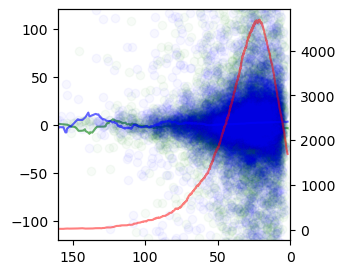

In [23]:
fig, ax1 = plt.subplots(figsize=(3,3))

df = dtheta_up.sort_values(by="distance")
mean = roll_func(df.mp_angle, df.distance,
          15, circmean, low=-np.pi, high=np.pi)*180/np.pi
ax1.plot(df.distance, df.mp_angle*180/np.pi, "og", alpha=.03)
ax1.plot(df.distance, mean, "-g", alpha=.6)

df = dtheta_down.sort_values(by="distance")
mean = roll_func(df.mp_angle, df.distance,
          15, circmean, low=-np.pi, high=np.pi)*180/np.pi
ax1.plot(df.distance, df.mp_angle*180/np.pi, "ob", alpha=.03)
ax1.plot(df.distance, mean, "-b", alpha=.6)
ax1.set_ylim([-120,120]); ax1.set_xlim([160,0])

num_of_samples = roll_func(1*df.mp_angle.abs(), df.distance,
          15, np.sum)
ax2 = ax1.twinx()
ax2.plot(df.distance, num_of_samples, "-r", alpha=.5)

# df_av_down = plot_rolling_average(df, ax1, "angm_rel_all", "distance", show=False, win=win, color="g", high=2/3*np.pi)
# # flip to negative values to show divergence
# ax1.plot(df_av_down["distance"], -120+df_av_down["angm_rel_all_ave"], "-", color="g", alpha=.6, linewidth=3,
#          label=r"$\langle \theta \rangle _{tr} < \pi$")
# ax1.fill_between(df_av_down.distance, 
#                  (-120+df_av_down["angm_rel_all_ave"])-df_av_down["angm_rel_all_std"], 
#                  (-120+df_av_down["angm_rel_all_ave"])+df_av_down["angm_rel_all_std"], 
#                  color="g", alpha=.2)


### Compare defect velocity (creation-fusion)

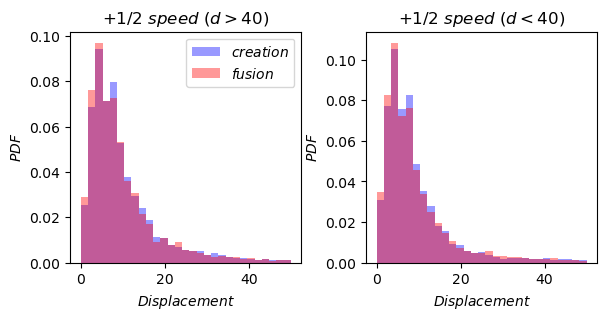

In [24]:
# create_df.shape, create_df.diff().shape
bins = np.linspace(0, 50, 30)

cr_df = create_df.reset_index()
cr_df["p_speed"] = (cr_df["xp"].diff()**2 + cr_df["yp"].diff()**2)**.5 / cr_df["FRAME"].diff()
cr_df = cr_df.dropna()

f_df = fuse_df.reset_index()
f_df["p_speed"] = (f_df["xp"].diff()**2 + f_df["yp"].diff()**2)**.5 / f_df["FRAME"].diff()
f_df = f_df.dropna()

fig, (ax1,ax2) = plt.subplots(1,2,  figsize=(7,3))

ax1.hist(cr_df["p_speed"][cr_df["distance"]>40], density=True, bins=bins, alpha=.4, color="b",
label=r"$creation$")
ax1.hist(f_df["p_speed"][f_df["distance"]>40], density=True, bins=bins, alpha=.4, color="r",
label=r"$fusion$")    

ax2.hist(cr_df["p_speed"][cr_df["distance"]<40], density=True, bins=bins, alpha=.4, color="b")
ax2.hist(f_df["p_speed"][f_df["distance"]<40], density=True, bins=bins, alpha=.4, color="r")

ax1.set_box_aspect(1); ax1.set_title(r"$+1/2 ~speed ~(d>40)$")
ax1.set_xlabel(r"$Displacement$"); ax1.set_ylabel(r"$PDF$")
ax2.set_box_aspect(1); ax2.set_title(r"$+1/2 ~speed  ~(d<40)$")
ax2.set_xlabel(r"$Displacement$"); ax2.set_ylabel(r"$PDF$")
ax1.legend(loc='upper right')

In [25]:
# FUSION
mp_distance_fusion_mat = np.zeros([len(mp_distance_fusion), len(max(mp_distance_fusion, key = lambda x: len(x)))])
mp_distance_fusion_mat[:] = np.nan
for i, dist in enumerate(mp_distance_fusion):
    # plt.plot(np.arange(len(dist)), np.flip(dist), alpha=.2)  
    mp_distance_fusion_mat[i,0:len(dist)] = np.flip(dist)

# CREATION
mp_distance_creation_mat = np.zeros([len(mp_distance_creation), len(max(mp_distance_creation, key = lambda x: len(x)))])
mp_distance_creation_mat[:] = np.nan
for i, dist in enumerate(mp_distance_creation):  
    # plt.plot(np.arange(len(dist)), dist, alpha=.2) 
    # plt.scatter(np.arange(len(dist)), dist, c=np.arange(len(dist)), s=5, alpha=.2, cmap="plasma")     
    mp_distance_creation_mat[i,0:len(dist)] = dist  

mean_fusion, stdiv_fusion = np.flip(np.nanmean(mp_distance_fusion_mat, axis=0)), np.flip(np.nanstd(mp_distance_fusion_mat, axis=0))
mean_creation, stdiv_creation = np.nanmean(mp_distance_creation_mat, axis=0), np.nanstd(mp_distance_creation_mat, axis=0)     

## Fit fusion-creation mean trajectories

FUSION
slope: -1.6497449705887925 | intercept: -30.752237482919615
Y=0 @ X=: -18.640600839015843
CREATION
slope: 3.05620428413051 | intercept: 28.248679286887626
Y=0 @ X=: -9.243059907209172


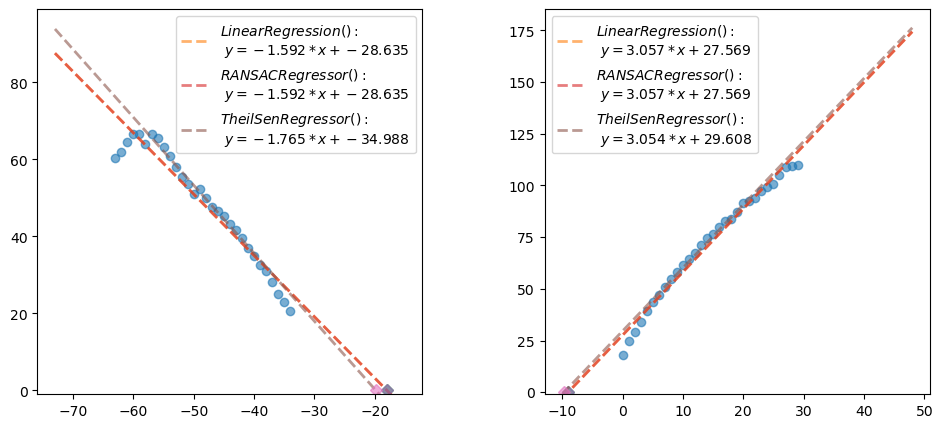

In [26]:
%matplotlib inline
from sklearn import linear_model

means = {"fusion": mean_fusion[-30:], "creation": mean_creation[:30]}
fig, axs = plt.subplots(1,2,  figsize=(12,5))
axs = axs.ravel()

lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

slope_intercept = {}

for ax, (name, mean) in zip(axs, means.items()):
    
    ave_slope, ave_intercept = 0, 0
    y = mean
    X = np.arange(len(mean))

    if name=="fusion":
        X = X - mp_distance_fusion_mat.shape[1]

    ax.plot(X, y, "o", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # prdict for line
        line_X = np.arange(X.min()-10, X.max()+20)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x + %.3f$" %(lr, slope, intercept))   
        ax.plot(-intercept/slope, 0, "D", alpha=.6,)        
        ave_slope += slope  
        ave_intercept += intercept

    # use prints to set the SLOPE and INTERCEP globals in the next cell
    print(name.upper())
    print('slope:', ave_slope/len(lrs), '| intercept:', ave_intercept/len(lrs))
    print('Y=0 @ X=:', -ave_intercept/ave_slope)
    slope_intercept[name] = {"slope": ave_slope/len(lrs), "intercept": ave_intercept/len(lrs)}


    ax.set_box_aspect(1)
    ax.set_ylim([-1,None])

    ax.legend(loc='upper left')
    if name=="fusion":
        ax.legend(loc='upper right')

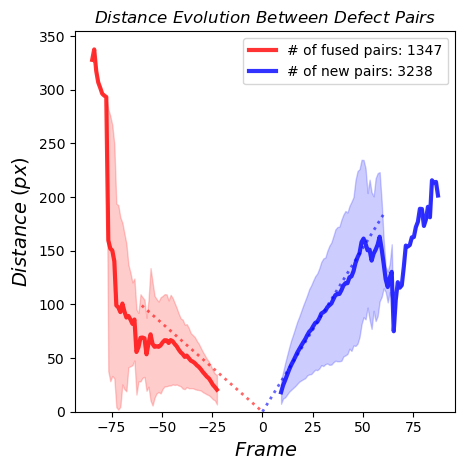

In [27]:
%matplotlib inline
SAVE = False
# FUSION
slope_fusion, intercept_fusion = slope_intercept["fusion"]["slope"], slope_intercept["fusion"]["intercept"] #-2.0 , 23.72
fusion_tshift = - intercept_fusion/slope_fusion -3
# mean_fusion, stdiv = np.flip(np.nanmean(mp_distance_fusion_mat, axis=0)), np.flip(np.nanstd(mp_distance_fusion_mat, axis=0))
time_fusion = np.arange(len(mean_fusion)) - mp_distance_fusion_mat.shape[1] + fusion_tshift

# uncomment to plot in same direction 
# mean, stdiv = np.nanmean(mp_distance_fusion_mat, axis=0), np.nanstd(mp_distance_fusion_mat, axis=0)
# max_frame = 0

plt.plot(time_fusion, mean_fusion, "r-", alpha=.8, linewidth=3,
    label="# of fused pairs: %s" % (mp_distance_fusion_mat.shape[0]))
plt.fill_between(time_fusion, mean_fusion-stdiv_fusion, mean_fusion+stdiv_fusion, color="red", alpha=.2)
xfit = np.array([-60,0])
plt.plot(xfit, slope_fusion * xfit, linestyle="dotted", color="red", alpha=.6, linewidth=2)

# CREATION
slope_creation, intercept_creation =  slope_intercept["creation"]["slope"], slope_intercept["creation"]["intercept"]#2.98, 27.25
creation_tshift = - intercept_creation/slope_creation
# mean_creation, stdiv = np.nanmean(mp_distance_creation_mat, axis=0), np.nanstd(mp_distance_creation_mat, axis=0)
time_creation = np.arange(len(mean_creation)) - creation_tshift

plt.plot(time_creation, mean_creation, "b-", alpha=.8, linewidth=3,
    label="# of new pairs: %s" % (mp_distance_creation_mat.shape[0]))
plt.fill_between(time_creation, mean_creation-stdiv_creation, mean_creation+stdiv_creation, color="b", alpha=.2)
xfit = np.array([0,60])
plt.plot(xfit, slope_creation * xfit, linestyle="dotted", color="b", alpha=.6, linewidth=2,
    )

plt.ylim([0,None])
lim = 60
# plt.xlim([-lim,lim])
plt.gca().set_box_aspect(1)  
plt.xlabel(r'$Frame$', fontsize=14)
plt.ylabel(r'$Distance ~(px)$', fontsize=14) #plt.ylabel('$Distance ~(\mu m)$')
plt.title(r'$Distance ~Evolution ~Between ~Defect ~Pairs$')
plt.tight_layout()
plt.legend()

if SAVE:
    plt.savefig(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\Images/defect_pair_distance.png")
 

In [28]:
def cofidence_range(X,y):
    import statsmodels.api as sm
    alpha = 0.05 # 95% confidence interval
    lr = sm.OLS(y, sm.add_constant(X)).fit()
    conf_interval = lr.conf_int(alpha)
    print("slope 95% CI ", "[%.2f, %.2f]" % (conf_interval[1][0], conf_interval[1][1]))    


for name, mean in means.items():
    y = mean
    X = np.arange(len(mean))
    print(name.upper())
    cofidence_range(X,y)

# Output of conf_interval
#  lower upper
# [-1.234 0.765]
# [-0.345 0.154]
# This means that we are 95% confident that the true value of the first parameter is between -1.234 and 0.765, 
# and we are 95% confident that the true value of the second parameter is between -0.345 and 0.154.

FUSION
slope 95% CI  [-1.75, -1.43]
CREATION
slope 95% CI  [2.90, 3.21]


## Flow Averaging Around Defects

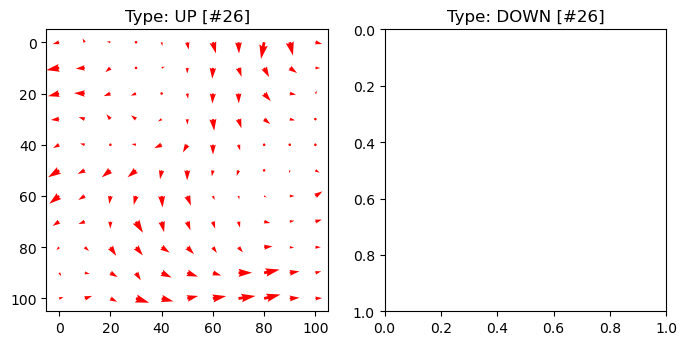

In [29]:
%matplotlib inline

from scipy.ndimage import rotate, gaussian_filter

def crop(img, center, width, height):
    ulx, uly = max(int(center[0] - width//2), 0), max(int(center[1] - height//2), 0)
    lrx, lry = min(int(center[0] + width//2), img.shape[1]), min(int(center[1] + height//2), img.shape[0])
    new_center = ((lrx-ulx)/2 , (lry-uly)/2)
    return img[uly:lry,ulx:lrx], new_center

def rotate_vector(vector, angle):
    '''rotate vectors'''
    x = vector[0] * np.cos(angle) - vector[1] * -np.sin(angle)
    y = vector[0] * -np.sin(angle) + vector[1] * np.cos(angle)
    return [x, y]    

def rotate_flow_field(flow, angle):
    '''rotate flow field'''
    uv_rot = rotate_vector(flow, angle)
    u = rotate(uv_rot[0], angle * 180/np.pi)
    v = rotate(uv_rot[1], angle * 180/np.pi)
    return [u, v]  

def defect_flow_frame_average(img1,img2, df_frame, defect_type="up", box=(150,150), filt=1):
    width, height = box[0], box[1]
    width1, height1 = int(width/2**.5), int(height/2**.5)
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    flow = gaussian_filter(flow, sigma=filt)

    if defect_type=="up":
        df = df_frame[df_frame.fuse_up].copy()
    elif defect_type=="down":
        df = df_frame[~df_frame.fuse_up].copy()
    else:
        df = df_frame.copy()


    u_frame = np.zeros((height1, width1), dtype=np.float32)
    v_frame = u_frame
    count = 0

    for i in range(len(df["xp"])):
        try:
            # center at defect position
            cnt = (int(df["xp"].iloc[i]), int(df["yp"].iloc[i]))
            #1 crop each component of velocity field
            
            # image_crop = crop(255-img_clahe, cnt, width, height)[0] *** image
            u,_ = crop(flow[:,:,0], cnt, width, height)
            v,_ = crop(flow[:,:,1], cnt, width, height)

            #2 rotate velocity field (1. rotate vectors 2. rotate positions) 
            # image_rot = rotate(image_crop, df["angp1"].iloc[i] * 180/np.pi) *** image
            uv_rot = rotate_flow_field((u,v), df["angp1"].iloc[i])

            #3 crop again to smaller box (box**0.5)
            cnt_crop = uv_rot[0].shape[1]/2, uv_rot[0].shape[0]/2
            # image_rot_crop = crop(image_rot, cnt_crop, width1, height1)[0] *** image
            u_frame = u_frame + crop(uv_rot[0], cnt_crop, width1, height1)[0]
            v_frame = v_frame + crop(uv_rot[1], cnt_crop, width1, height1)[0]
            count += 1 
        except:
            pass
        #      break

    if count:
        return u_frame/count, v_frame/count, count

image_list = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\*.tif")
image_list = natsorted(image_list, key=lambda y: y.lower())

frame = 51
img1 = cv2.imread(image_list[frame])[:,900:,0]
img2 = cv2.imread(image_list[frame+1])[:,900:,0] 
# df_frame = all_pairs_df[all_pairs_df.index == frame]
df_frame = all_pairs_df[all_pairs_df.index == frame]

u_up, v_up, count_up = defect_flow_frame_average(img1,img2, df_frame, defect_type="all")
# u_dwn, v_dwn, up_dwn = defect_flow_frame_average(img1,img2, df_frame, defect_type="down")
y, x = np.mgrid[0:u_up.shape[0], 0:u_up.shape[1]] 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
step = 10
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], -v_up[::step, ::step],  color='r',
          width=.01, scale=10,)
ax1.set_title("Type: %1s [#%1d]" % ("UP", count_up))
ax1.set_box_aspect(1) ; ax1.invert_yaxis()

# ax2.quiver(x[::step, ::step], y[::step, ::step], 
#           u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='b',
#           width=.01, scale=10,)
# ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))
ax2.set_title("Type: %1s [#%1d]" % ("DOWN", count_up))
ax2.set_box_aspect(1) ; ax2.invert_yaxis()


In [30]:
all_pairs_df[all_pairs_df.index == 51]

plus_id      xp     yp     angp1  min_id      xm     ym     angm1  \
FRAME                                                                      
51       185.0   274.0  506.0  3.015929    44.0   126.0  442.0 -1.759292   
51       417.0  1267.0  453.0 -2.827433   352.0  1216.0  473.0  2.010619   
51       389.0   973.0   19.0  1.822124   364.0   902.0   16.0  1.570796   
51       447.0  1202.0  814.0 -2.450442   407.0  1196.0  807.0 -1.068142   
51       497.0   655.0  522.0 -1.633628   418.0   651.0  492.0  3.078761   
51       459.0  1731.0  444.0  1.696460   420.0  1572.0  488.0 -0.188496   
51       533.0   728.0  600.0  1.696460   502.0   732.0  595.0  1.068142   
51       532.0  1638.0  595.0  2.638938   504.0  1749.0  557.0  2.827433   
51       501.0   462.0  509.0 -1.884956   507.0   446.0  520.0 -0.125664   
51       380.0   843.0  435.0  2.953097   508.0   844.0  560.0 -1.884956   
51       497.0   655.0  522.0 -1.633628   509.0   689.0  463.0  0.125664   
51       539.0  1210.0  453.0 -0.753982   511.0  1243.0  425.0 -1.256637   
51       519.0  1779.0  807.0 -3.141593   536.0  1780.0  784.0  3.015929   
51       449.0  1023.0  744.0  1.005310   537.0  1038.0  738.0  1.319469   
51       571.0   914.0  746.0 -0.188496   538.0   942.0  769.0 -0.753982   
51       528.0   544.0  698.0 -1.822124   541.0   587.0  646.0  1.570796   
51       573.0  1485.0  690.0 -2.136283   543.0  1494.0  651.0  1.319469   
51       549.0   544.0   45.0  2.010619   559.0   576.0   52.0 -2.764602   
51       110.0   206.0  278.0  2.576106   580.0   192.0  181.0  3.015929   
51       589.0  1049.0   68.0 -0.125664   582.0  1040.0   16.0  1.696460   
51       459.0  1731.0  444.0  1.696460   586.0  1692.0  485.0  3.078761   
51       578.0   900.0  430.0  0.000000   594.0   941.0  440.0 -2.701770   
51        64.0   363.0  308.0  2.010619   598.0   382.0  270.0  0.251327   
51       584.0   338.0  249.0 -1.696460   600.0   329.0  248.0 -2.450442   
51       585.0  1436.0  212.0 -0.062832   602.0  1366.0  237.0  2.010619   
51       546.0  1779.0  178.0 -2.576106   603.0  1747.0  183.0  0.062832   
51       626.0   185.0  836.0  0.816814   609.0   185.0  810.0 -1.884956   
51       590.0   777.0  707.0 -1.759292   612.0   784.0  669.0 -1.319469   
51       595.0   855.0  620.0 -3.141593   613.0   856.0  592.0 -3.141593   
51       597.0   987.0  550.0 -0.314159   614.0   980.0  532.0 -0.376991   
51       603.0   337.0  432.0  1.507964   615.0   341.0  423.0  0.753982   
51       606.0  1590.0  358.0  0.628319   618.0  1623.0  386.0 -0.314159   
51        64.0   363.0  308.0  2.010619   619.0   407.0  261.0 -0.251327   
51       614.0  1408.0  163.0 -0.628319   621.0  1425.0  178.0 -2.199115   
51       613.0   904.0  182.0 -0.125664   622.0   904.0  197.0  1.696460   
51       612.0   858.0  172.0  2.387610   627.0   857.0  164.0  2.324779   
51       616.0  1102.0   77.0  2.701770   628.0  1068.0   51.0  0.314159   
51       620.0   199.0   34.0  1.633628   630.0   223.0   30.0  1.507964   
51       593.0  1162.0  649.0 -1.696460   635.0  1142.0  610.0 -0.502655   
51       598.0  1674.0  530.0  2.010619   636.0  1678.0  544.0  0.125664   
51       530.0   186.0  625.0  0.251327   637.0   103.0  590.0 -2.199115   
51       600.0   513.0  519.0  0.628319   640.0   512.0  533.0  0.125664   
51       607.0  1301.0  368.0 -0.251327   641.0  1279.0  376.0  2.199115   
51       624.0   589.0  873.0 -1.696460   646.0   546.0  869.0  2.953097   
51       632.0   704.0  858.0  1.822124   647.0   710.0  875.0  0.376991   
51       633.0  1777.0  854.0  2.638938   649.0  1787.0  843.0  1.382301   
51       594.0   981.0  638.0 -1.633628   655.0  1019.0  623.0 -2.010619   
51       637.0  1297.0  630.0  0.062832   656.0  1309.0  638.0 -2.638938   
51       639.0   627.0  507.0  1.193805   657.0   611.0  496.0 -1.068142   
51       604.0   705.0  431.0  0.188496   661.0   725.0  408.0  2.199115   
51       340.0  1243.0  307.0  1.319469   669.0  1246.0

# ------------ TRIES --------------------

            params     sigma
mu1       0.901669  0.003664
sigma1    0.193545  0.003874
A1      147.740700  2.081777
mu2       1.604523  0.005555
sigma2    0.208389  0.005988
A2      100.580279  2.021162


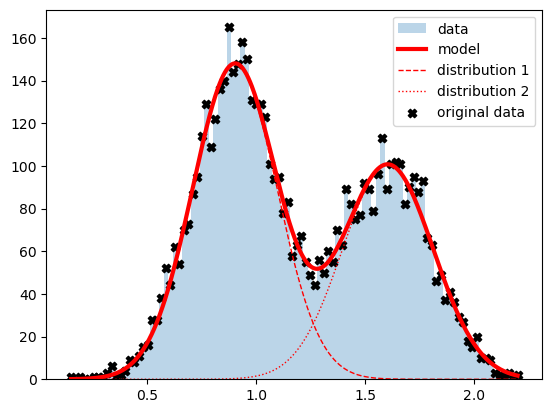

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
data = np.concatenate((np.random.normal(.9, .2, 3500), np.random.normal(1.6, .2, 2500)))
y,x,_= plt.hist(data, 100, alpha=.3, label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1) + gauss(x,mu2,sigma2,A2)

expected = (.8, .2, 250, 1.8, .2, 125)
params, cov = curve_fit(bimodal, x, y, expected)
sigma = np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
#...and individual Gauss curves
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
#and the original data points if no histogram has been created before
plt.scatter(x, y, marker="X", color="black", label="original data")
plt.legend()
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show() 

(0.9029628377210909, 0.0020159130483440495, 0.0005729815563985407)

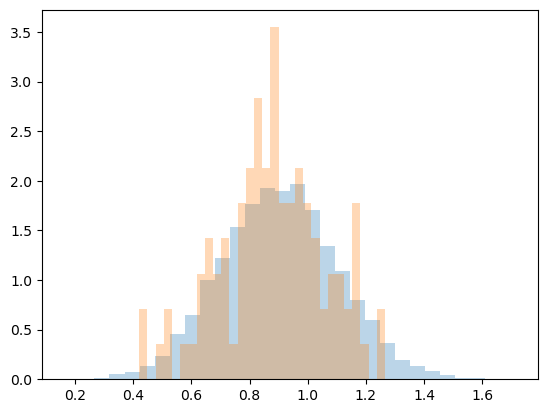

In [32]:
# import numpy as np
# from scipy.stats import sem
a = np.random.normal(.9, .2, 10000)
plt.hist(a, 30, alpha=.3, density=True)
plt.hist(a[:100], 30, alpha=.3, density=True)
# plt.plot(np.arange(len(a)), a, alpha=.3)
a.mean(), sem(a), sem(a[:100])/1000**.5